<a href="https://colab.research.google.com/github/nicknovoa03/Stock-trader/blob/Nick-Dev/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Unzip stock  to have access to files in notebook enviorment
  * using in google colab


In [0]:
import zipfile

zname = 'stocks.zip'

with zipfile.ZipFile(zname,'r') as zip_ref:
  zip_ref.extractall()

##Import all information from quotes from their .csv's
* 'date', 'open', 'high', 'low', 'close', 'adjclose', 'volume' for each stock

In [0]:
import numpy as np
import pandas as pd
from statistics import mean
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# All lists and Dictionaries ordered from most recent to oldest
dfdic = {}
closeDF = {}

# Date,Open,High,Low,Close,Adj Close,Volume
# 1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023007,117258400
# 1980-12-15,0.488839,0.488839,0.486607,0.486607,null,43971200
# ...
dirpath = 'stocks/quotes'
for file in os.listdir(dirpath):
    symbol = os.path.splitext(file)[0]
    if symbol[0] == '.':
      continue
    #print('Stock:',symbol)
    path = dirpath + '/' + file
    
    dfdic[symbol] = pd.read_csv(path)
    


In [132]:
dfdic[symbol]['Close']

array([  0.513393,   0.486607,   0.450893, ..., 194.020004, 195.350006,
       195.690002])

##Calculate Small Moving Averages using Pandas
 * return a dictionay where each key is the symbol and the value is a pandas DataFrame with the moving average for that day

In [0]:
def calcSMA(period):
  temp = {}
  start = 0
  sma = 0
  for sym,val in dfdic.items():
    #check if length of all closing values is bigger than the period
    val = val.loc[:,'Close']
    if val.size-period < 0:
      print(val,"closing array length of:",val.size,"...expected ~",start+period-1)
      continue
    #get the SMA for each stock with pandas
    sma = val.rolling(window=period).mean()
    #Add to temp dictionary with key being the symbol and value is SMA
    temp[sym] = sma
  return temp


In [142]:
sma50 = calcSMA(50)
#print("sma50 = %s" %sma50)
#print("Sma50 Length = %d" %len(sma50))

sma10 = calcSMA(10)
#print("sma10 = %s" %sma10)
#print("Sma10 Length = %d" %len(sma10))

sma100 = calcSMA(100)


9655    173.7006
9656    174.4082
9657    175.1522
9658    175.9932
9659    176.8286
Name: Close, dtype: float64

##calculate the Exponential Moving Average 
* return a dictionay where each key is the symbol and the value is a pandas DataFrame with the exponential moving averages for each day

In [0]:
def calcEMA(period):
  temp = {}
  start = 0
  ema = 0
  for sym,val in dfdic.items():
    #check if length of all closing values is bigger than the period
    val = val.loc[:,'Close']
    if val.size-period < 0:
      print(val,"closing array length of:",val.size,"...expected ~",start+period-1)
      continue
    #get the EMA using pandas
    ema = val.ewm(span = period, adjust = False).mean()
    #add to dictionary with key being the symbol and value is a pandas DataFrame
    temp[sym] = ema
  return temp

ema50 = calcEMA(50)
#print("sma50 = %s" %sma50)
#print("Sma50 Length = %d" %len(sma50))

ema100 = calcEMA(100)
#print("ema10 = %s" %ema10)
#print("ema10 Length = %d" %len(ema10))

ema20 = calcEMA(20)

##Candlestick graph with SMA and EMA

In [0]:
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

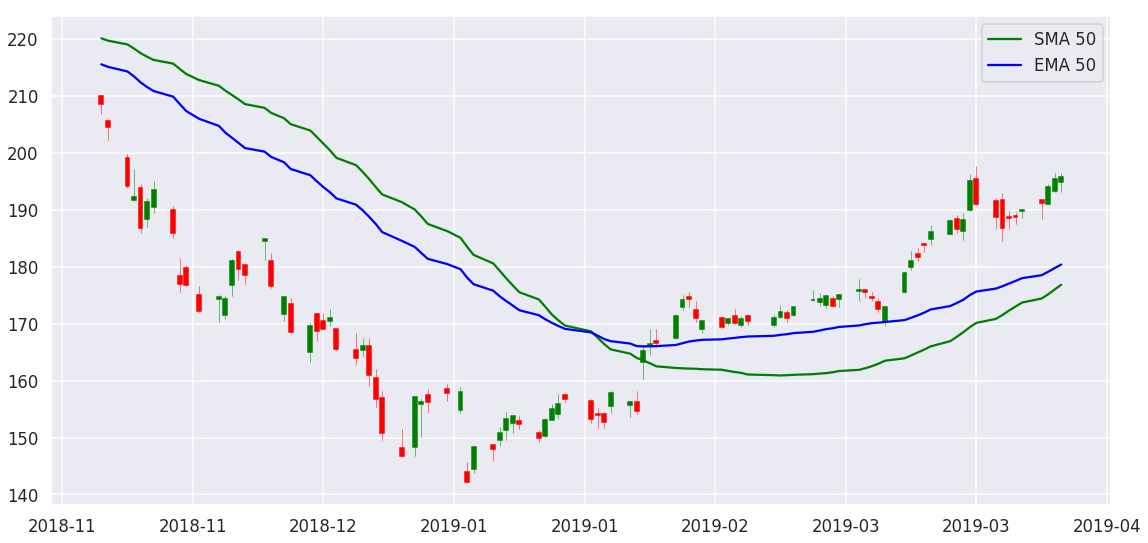

In [152]:
from mpl_finance import candlestick_ohlc
import seaborn as sns

sns.set(style='darkgrid', context='talk', palette='Dark2')
symbol = 'AAPL'
period = 100
span = 20
df = dfdic['AAPL'].tail(period).copy()

df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].apply(mdates.date2num)

ohlc= df[['Date', 'Open', 'High', 'Low','Close']].copy()

ohlc.tail(period)

f1, ax = plt.subplots(figsize = (19,9))

#plot
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='g',colordown='r')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

#get SMA
ohlc['SMA'] = sma50[symbol].tail(period).values
ohlc['EMA'] = ema50[symbol].tail(period).values

ax.plot(ohlc['Date'], ohlc['SMA 50'], color='g', label='SMA 50')
ax.plot(ohlc['Date'], ohlc['EMA 50'], color='b', label='EMA 50')

plt.legend(loc=1)
plt.show()
#type(df.tail()['Date'].values[0])
#ohlc.tail()
#sma50[symbol].tail(period).values

##Plot closing prices with SMA of 50 and 100 days

In [0]:
symbol = 'MSFT'
sd = '2017-01-03'
ed = '2019-04-01'

my_year_month_fmt = mdates.DateFormatter('%m/%y')

#concatinate dataframes
df = closeDF[symbol]
smas = sma50[symbol]
smab = sma100[symbol]
df = pd.concat([df,smas],axis=1)
df = pd.concat([df,smab],axis=1)
df.columns = [symbol,'SMA 50','SMA 100']

#change index to datetime format from str
df.index = pd.to_datetime(df.index)
#plot date
fig, ax = plt.subplots(figsize=(15,9))
df.loc[sd:ed,:].plot(ax=ax)

#set ticks every day
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(my_year_month_fmt)

##Plot closing prices with EMA and SMA

In [0]:
symbol = 'AAPL'
sd = '2015-01-01'
ed = '2017-01-03'

my_year_month_fmt = mdates.DateFormatter('%m/%y')

#concatinate dataframes
df = closeDF[symbol].copy()
smas = sma50[symbol]
emas = ema50[symbol]
df = pd.concat([df,smas],axis=1)
df = pd.concat([df,emas],axis=1)
df.columns = [symbol,'SMA 50','EMA 50']

#change index to datetime format from str
df.index = pd.to_datetime(df.index)
#plot date
fig, ax = plt.subplots(figsize=(15,9))
df.loc[sd:ed,:].plot(ax=ax)

#set ticks every day
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [0]:
dydxAvg = 0
dydx2Avg = 0
dydxList = []
dydx2List = []

def CalcDydx(l):
    global dydxList
    global dydxAvg
    dx = 1
    dydxList = list(numpy.diff(smaList) / dx)
    dydxAvg = mean(dydxList)

def calcDydx2():
    global dydx2List
    global dydx2Avg
    dx = 1
    dydx2List = list(numpy.diff(dydxList) / dx)
    dydx2Avg = mean(dydx2List)


CalcDydx()
print("Dydx Length=%d" %len(dydxList))
print("Dydx2 Length=%d" %len(dydx2List))
printList(dydxList, "dy/dx List")
printList(dydx2List, "d2y/dx2 List")

In [0]:
#  (12 * (p0 / p1 – 1))
# + (4 * (p0 / p3 – 1))
# + (2 * (p0 / p6 – 1))
# +      (p0 / p12 – 1)
# Where p0 = the asset price at today’s close, 
# p1 = the asset price at the close of the previous month, etc.

today = datetime.datetime.today().strftime('%Y/%m/%d')
momentum = [0 for x in range(0,4)]
confidence = 0

def dayDif(d1, d2):
    d1 = datetime.strptime(d1, '%Y/%m/%d')
    d2 = datetime.strptime(d2, '%Y/%m/%d')
    return abs((d2 - d1).days)
    
def calcMomentum():
    global momentum
    p0=0.0; p1=0.0; p3=0.0; p6=0.0; p12=0.0
    months = ['12','11','10','09','08','07','06','05','04','03','02','01','12','11','10','09','08','07','06','05','04','03','02','01']
    p0_mn = dateList[0][5:7] # current month
    p1_mn = months[months.index(p0_mn)+1]
    p3_mn = months[months.index(p0_mn)+3]
    p6_mn = months[months.index(p0_mn)+6]
    p12_mn = months[months.index(p0_mn)+12]
    
    #print("p0_mn=%s, p1_mn=%s, p3_mn=%s, p6_mn=%s, p12_mn=%s" %(p0_mn,p1_mn,p3_mn,p6_mn,p12_mn))
    for d in dateList:
        dates = d.split("/")
        if dates[1] == p0_mn and p0 == 0:
            p0 = float(closeDic[d])
            #print("%s : p0=%f\n" %(d,p0))
        elif dates[1] == p1_mn and p1 == 0:
            p1 = float(closeDic[d])
            #print("%s : p1=%f\n" %(d,p1))
        elif dates[1] == p3_mn and p3 == 0:
            p3 = float(closeDic[d])
            #print("%s : p3=%f\n" %(d,p3))
        elif dates[1] == p6_mn and p6 == 0:
            p6 = float(closeDic[d])
            #print("%s : p6=%f\n" %(d,p6))
        elif dates[1] == p12_mn and p12 == 0 and p6 != 0: 
            p12 = float(closeDic[d])
            #print("%s : p12=%f\n" %(d,p12))
            break
    
    #print("p0=%f, p1=%f, p3=%f, p6=%f, p12=%f" %(p0,p1,p3,p6,p12))
    momentum[0] = 12 * (p0 / p1 - 1)
    momentum[1] = 4 * (p0 / p3 - 1)
    momentum[2] = 2 * (p0 / p6 - 1)
    momentum[3] = 1 * (p0 / p12 - 1)
    print("momentum[0]=%f \nmomentum[1]=%f \nmomentum[2]=%f\nmomentum[3]=%f" %(momentum[0],momentum[1],momentum[2],momentum[3]))
    confidence = momentum[0] + momentum[1] + momentum[2] + momentum[3]
    return confidence


print("Today is %s" %today)
confidence = calcMomentum()
print("Confidence: %f" %confidence)
#printDateList()
printList(momentum, "Momentum List")